# AWS SageMaker Linear Learner - Abalone

This notebook walks through how to use the Linear Learner Machine Learning algorithm with the Abalone Dataset.

You can find the dataset here:

https://archive.ics.uci.edu/ml/datasets/Abalone

This example was inspired by the AWS Article: 

https://aws.amazon.com/blogs/machine-learning/preprocess-input-data-before-making-predictions-using-amazon-sagemaker-inference-pipelines-and-scikit-learn/




In [1]:
import warnings
warnings.filterwarnings("ignore")
import boto3
from sagemaker import get_execution_role
import sys,os
import pandas as pd
import numpy as np
import sagemaker.amazon.common as smac
import io
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from io import StringIO
import json
from sklearn import metrics
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Setup variables to point to S3
filename = 'abalone_recordio_train.data'
bucket = 'pryan-sagemaker-east'
prefix = 'abalone'
raw_prefix = 'raw'
dataset_name = 'abalone.data'
data_dir='dataset'
train_prefix = 'train'
output_prefix = 'output'
train_path = f"{prefix}/{train_prefix}/{filename}"
s3_train_data = f"s3://{bucket}/{train_path}"
output_location = f's3://{bucket}/{prefix}/{output_prefix}'


In [3]:
# Setup environment variables that will be used when issuing AWS cli commands
%env DATA_DIR=$data_dir
%env S3_DATA_BUCKET_NAME = $bucket/$prefix/$raw_prefix
%env DATASET_NAME = $dataset_name
%env TRAINING_PATH = $bucket/$train_prefix


env: DATA_DIR=dataset
env: S3_DATA_BUCKET_NAME=pryan-sagemaker-east/abalone/raw
env: DATASET_NAME=abalone.data
env: TRAINING_PATH=pryan-sagemaker-east/train


In [4]:
# Pull data from S3
!aws s3 cp s3://$S3_DATA_BUCKET_NAME/$DATASET_NAME ./$DATA_DIR/

download: s3://pryan-sagemaker-east/abalone/raw/abalone.data to dataset/abalone.data


In [5]:
column_names = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
df = pd.read_csv('./dataset/abalone.data', names=column_names)

df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [6]:
df.shape

(4177, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
sex               4177 non-null object
length            4177 non-null float64
diameter          4177 non-null float64
height            4177 non-null float64
whole_weight      4177 non-null float64
shucked_weight    4177 non-null float64
viscera_weight    4177 non-null float64
shell_weight      4177 non-null float64
rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [8]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [9]:
numeric_features = list(df.select_dtypes([np.number]).columns)
X = df[numeric_features].copy()
X.drop(columns=['rings'], axis=1, inplace=True)
y = df['rings']



In [10]:
# create a holdout set, 5%
X_train, X_holdout, y_train, y_holdout = train_test_split(X,y, test_size=0.05)


In [11]:
X_train.shape

(3968, 7)

In [12]:
X_holdout.shape

(209, 7)

In [13]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(X_train).astype('float32'), np.array(y_train).astype('float32'))
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(f'{train_path}').upload_fileobj(buf)


In [14]:
container = get_image_uri(boto3.Session().region_name, 'linear-learner')


In [15]:
sess = sagemaker.Session()

role = get_execution_role()


linear = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

linear.set_hyperparameters(feature_dim=7, epochs=20, num_models=32, loss='absolute_loss',
                       predictor_type='regressor', 
                       mini_batch_size=32, 
                      normalize_data=True, normalize_label=False)

linear.fit({'train': s3_train_data}, job_name=f"job-abalone-{int(time.time())}")
    

2019-12-05 20:27:08 Starting - Starting the training job...
2019-12-05 20:27:10 Starting - Launching requested ML instances......
2019-12-05 20:28:15 Starting - Preparing the instances for training......
2019-12-05 20:29:31 Downloading - Downloading input data...
2019-12-05 20:30:03 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[12/05/2019 20:30:05 INFO 140217849235264] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr

[2019-12-05 20:30:15.047] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 10, "duration": 2129, "num_examples": 124, "num_bytes": 285696}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.7157228411205354, "sum": 1.7157228411205354, "min": 1.7157228411205354}}, "EndTime": 1575577815.047168, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575577815.047084}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.6967687827925528, "sum": 1.6967687827925528, "min": 1.6967687827925528}}, "EndTime": 1575577815.047255, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575577815.047238}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.7212018856117803, "sum": 1.7212018856117803, "min": 1.7212018856117803}}, "EndTime": 1575577

[2019-12-05 20:30:25.947] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 20, "duration": 1941, "num_examples": 124, "num_bytes": 285696}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.6505272345196815, "sum": 1.6505272345196815, "min": 1.6505272345196815}}, "EndTime": 1575577825.947921, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1575577825.947842}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.6220298044143184, "sum": 1.6220298044143184, "min": 1.6220298044143184}}, "EndTime": 1575577825.947994, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1575577825.947981}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.6529209416720174, "sum": 1.6529209416720174, "min": 1.6529209416720174}}, "EndTime": 1575577

[2019-12-05 20:30:37.046] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 30, "duration": 2167, "num_examples": 124, "num_bytes": 285696}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.6323264048945518, "sum": 1.6323264048945518, "min": 1.6323264048945518}}, "EndTime": 1575577837.046252, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1575577837.04617}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.601246595863373, "sum": 1.601246595863373, "min": 1.601246595863373}}, "EndTime": 1575577837.046328, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 13}, "StartTime": 1575577837.04631}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.6338944959063684, "sum": 1.6338944959063684, "min": 1.6338944959063684}}, "EndTime": 1575577837

[2019-12-05 20:30:50.114] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 42, "duration": 2288, "num_examples": 124, "num_bytes": 285696}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.6239128555020979, "sum": 1.6239128555020979, "min": 1.6239128555020979}}, "EndTime": 1575577850.114136, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1575577850.114057}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.5924438531360319, "sum": 1.5924438531360319, "min": 1.5924438531360319}}, "EndTime": 1575577850.114209, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 19}, "StartTime": 1575577850.114197}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 1.6252513922029925, "sum": 1.6252513922029925, "min": 1.6252513922029925}}, "EndTime": 15755


2019-12-05 20:31:01 Uploading - Uploading generated training model
2019-12-05 20:31:01 Completed - Training job completed
Training seconds: 90
Billable seconds: 90


In [16]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium', endpoint_name="abalone-endpoint")


--------------------------------------------------------------------------------------------------------------------------!

In [17]:
X_holdout.values

array([[0.545 , 0.43  , 0.165 , ..., 0.2935, 0.183 , 0.28  ],
       [0.525 , 0.415 , 0.145 , ..., 0.3525, 0.1635, 0.2875],
       [0.545 , 0.41  , 0.14  , ..., 0.349 , 0.15  , 0.212 ],
       ...,
       [0.275 , 0.195 , 0.09  , ..., 0.0545, 0.0295, 0.0355],
       [0.31  , 0.235 , 0.075 , ..., 0.056 , 0.0315, 0.05  ],
       [0.68  , 0.53  , 0.185 , ..., 0.439 , 0.245 , 0.34  ]])

In [18]:
X_holdout.shape

(209, 7)

In [19]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [20]:
result = linear_predictor.predict(X_holdout.values)


In [21]:
predictions = [ x['score'] for x in result["predictions"]]

# compute the RMSE of our predictions
print(f"RSME: {np.sqrt(metrics.mean_squared_error(y_holdout.values, predictions))}")



RSME: 2.072377953797305


In [22]:
# Use Holdout DataSet
print("Holdout DataSet")
prediction_df = pd.DataFrame({
        'actual rings': y_holdout.values,
        'predicted rings': predictions
    })
prediction_df['rings diff'] = prediction_df['actual rings'] - prediction_df['predicted rings']
prediction_df.head()




Holdout DataSet


,actual rings,predicted rings,rings diff
0,11,11.406343,-0.406343
1,8,10.487759,-2.487759
2,9,9.126325,-0.126325
3,6,8.144827,-2.144827
4,16,9.238882,6.761118


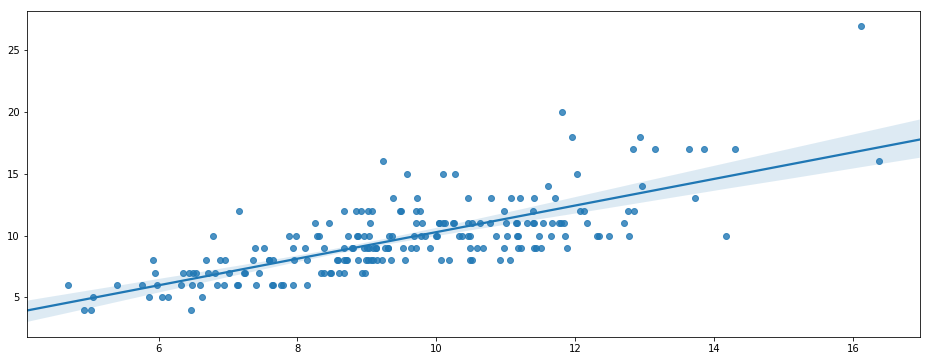

In [23]:
plt.figure(figsize=(16, 6))
sns.regplot(np.array(predictions),np.array(y_holdout.values))


In [24]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)